# Slide-Seq Mouse Olfactory Bulb - single puck

This example uses TACCO to annotate and analyse mouse olfactory bulb Slide-Seq data (Wang et al.) with mouse olfactory bulb scRNA-seq data (Tepe et al.) as reference.

(Wang et al.): Wang IH, Murray E, Andrews G, Jiang HC et al. Spatial transcriptomic reconstruction of the mouse olfactory glomerular map suggests principles of odor processing. Nat Neurosci 2022 Apr;25(4):484-492. PMID: 35314823

(Tepe et al.): Tepe B, Hill MC, Pekarek BT, Hunt PJ et al. Single-Cell RNA-Seq of Mouse Olfactory Bulb Reveals Cellular Heterogeneity and Activity-Dependent Molecular Census of Adult-Born Neurons. Cell Rep 2018 Dec 4;25(10):2689-2703.e3. PMID: 30517858

In [1]:
import os
import warnings
warnings.filterwarnings('ignore','invalid value encountered in true_divide')

import pandas as pd
import numpy as np
import anndata as ad

import tacco as tc

## Load data

In [2]:
# The notebook expects to be executed either in the workflow directory or in the repository root folder
data_path = 'results/slideseq_mouse_olfactory_bulb'
if not os.path.exists(data_path):
    data_path = f'../../{data_path}'

if not os.path.exists(data_path):
    raise ValueError(f'The path to the data for the slideseq_mouse_olfactory_bulb cannot be found!')


In [3]:
reference = ad.read(f'{data_path}/reference.h5ad')

In [4]:
puck = ad.read(f'{data_path}/puck_1_5.h5ad')

## Get a first impression of the spatial data

Plot total counts

In [5]:
puck.obs['total_counts'] = tc.sum(puck.X,axis=1)
puck.obs['log10_counts'] = np.log10(1+puck.obs['total_counts'])

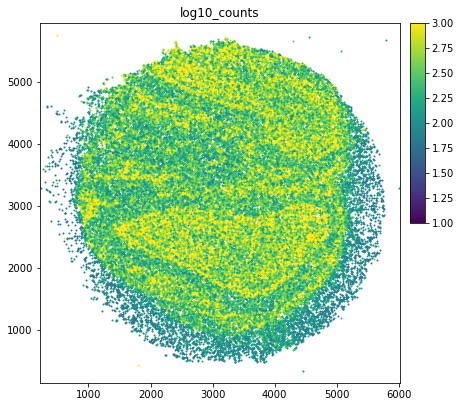

In [6]:
fig = tc.pl.scatter(puck, 'log10_counts', cmap='viridis', cmap_vmin_vmax=[1,3]);
fig.savefig(f'{data_path}/scatter_counts_single.pdf',bbox_inches='tight')

Plot marker genes

In [7]:
cluster2type = reference.obs[['ClusterName','type']].drop_duplicates().groupby('type')['ClusterName'].agg(lambda x: list(x.to_numpy()))
type2long = reference.obs[['type','long']].drop_duplicates().groupby('long')['type'].agg(lambda x: list(x.to_numpy()))

In [8]:
marker_map = {}
for k,v in type2long.items():
    genes = []
    if '(' in k:
        genes = k.split('(')[-1].split(')')[0].split('/')
    marker_map[v[0]] = [g[:-1] for g in genes]

In [9]:
puck.obsm['type_mrk'] = pd.DataFrame(0.0, index=puck.obs.index, columns=sorted(reference.obs['type'].unique()))
for k,v in marker_map.items():
    for g in v:
        puck.obsm['type_mrk'][k] += puck[:,g].X.A.flatten()
    total = puck.obsm['type_mrk'][k].sum()
    if total > 0:
        puck.obsm['type_mrk'][k] /= total

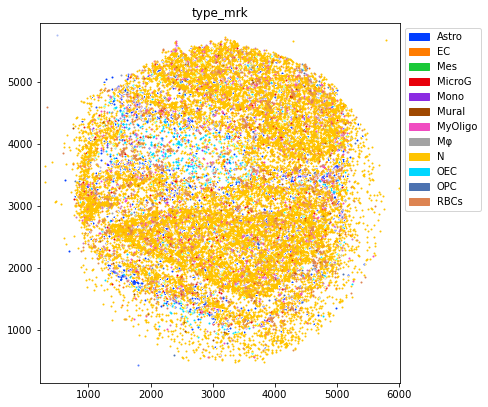

In [10]:
fig=tc.pl.scatter(puck, 'type_mrk', compositional=True);
fig.savefig(f'{data_path}/scatter_marker_single.pdf',bbox_inches='tight')

## Annotate the spatial data with compositions of cell types

Annotation is done on cluster level to capture variation within a cell type...

In [11]:
tc.tl.annotate(puck,reference,'ClusterName',result_key='ClusterName',)

Starting preprocessing
Annotation profiles were not found in `reference.varm["ClusterName"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 16.61 seconds.
Starting annotation of data with shape (44311, 17402) and a reference of shape (51426, 17402) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=ClusterName, normalize_to=adata
   +- multi center: multi_center=None multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.6226693400821371 8.439594522464825


/ahg/regevdata/projects/mouse_CRC/rerun/tacco_examples/.snakemake/conda/842233885b1b580a14864e15a669812f/lib/python3.10/site-packages/tacco/tools/_annotate.py:176: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(adata.X.copy(), obs=adata.obs[[]], var=adata.var[[]])


bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 19.72 seconds.


AnnData object with n_obs × n_vars = 44311 × 22170
    obs: 'x', 'y', 'total_counts', 'log10_counts'
    obsm: 'type_mrk', 'ClusterName'
    varm: 'ClusterName'

... and then aggregated to cell type level for visualization

In [12]:
tc.utils.merge_annotation(puck, 'ClusterName', cluster2type, 'type');
tc.utils.merge_annotation(puck, 'type', type2long, 'long');

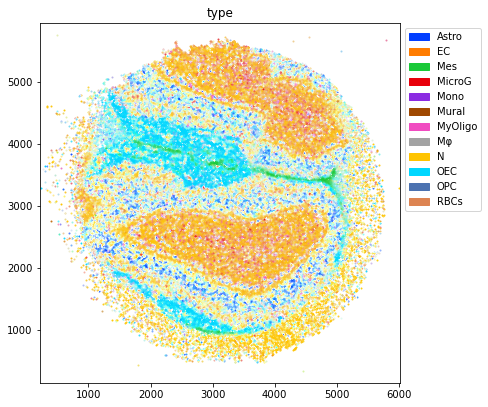

In [13]:
fig = tc.pl.scatter(puck, 'type', );
fig.savefig(f'{data_path}/scatter_type_single.pdf',bbox_inches='tight')

## Analyse co-occurrence and neighbourhips

Calculate distance matrices per sample and evaluate different spatial metrics on that. Using sparse distance matrices is useful if one is interested only in small distances relative to the sample size.

In [14]:
tc.tl.co_occurrence(puck, 'type', result_key='type-type',delta_distance=20,max_distance=1000,sparse=False,n_permutation=10)

co_occurrence: The argument `distance_key` is `None`, meaning that the distance which is now calculated on the fly will not be saved. Providing a precalculated distance saves time in multiple calls to this function.
calculating distance for sample 1/1


AnnData object with n_obs × n_vars = 44311 × 22170
    obs: 'x', 'y', 'total_counts', 'log10_counts'
    uns: 'type-type'
    obsm: 'type_mrk', 'ClusterName', 'type', 'long'
    varm: 'ClusterName'

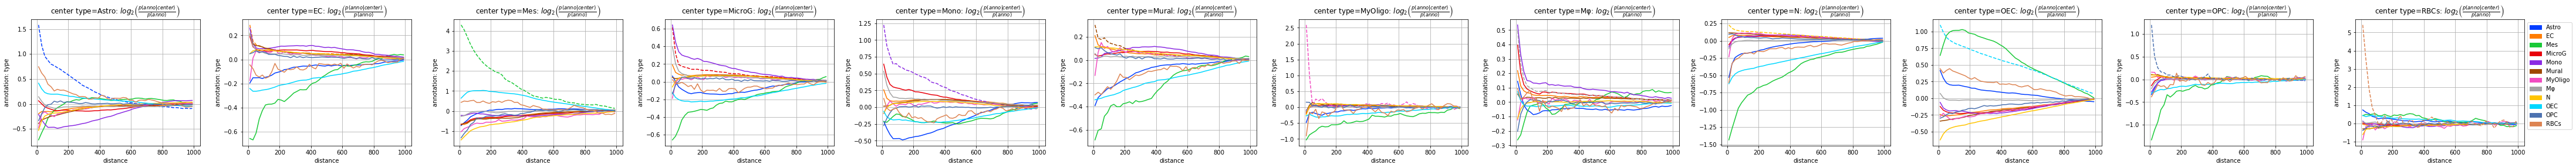

In [15]:
fig = tc.pl.co_occurrence(puck, 'type-type', log_base=2, wspace=0.25);
fig.savefig(f'{data_path}/cooc_line_single.pdf',bbox_inches='tight')

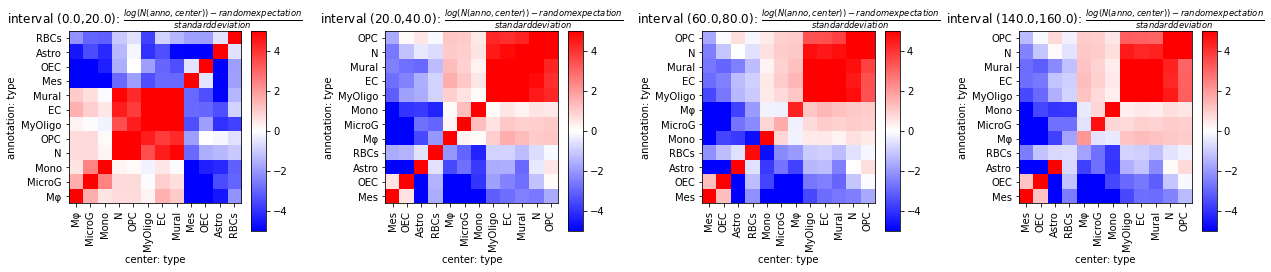

In [16]:
fig = tc.pl.co_occurrence_matrix(puck, 'type-type', score_key='z', restrict_intervals=[0,1,3,7],cmap_vmin_vmax=[-5,5], value_cluster=True, group_cluster=True);
fig.savefig(f'{data_path}/cooc_matrix_single.pdf',bbox_inches='tight')